# Accessing DC2 data in PostgreSQL at NERSC

Owner: **Joanne Bogart [@jrbogart](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jrbogart)**  
Last Verified to Run: 

This notebook is an introduction to use of the PostgreSQL database at NERSC.  Currently the fully supported datasets are the object catalogs for Run1.2i, Run1.2p v4, and run2.1i dr1b v1. Since object catalogs as well as other kinds of catalogs are also available via GCR one might question the need for another form of access.  The justification (for those applications only using object catalogs) is performance. Typical queries such as the one labeled `q5` below run significantly faster.  Ingest also tends to be faster. The Run1.2p v4 data were available via PostgreSQL within a day of the completion of stack processing and transfer to NERSC.

__Learning objectives__:

After going through this notebook, you should be able to:
  1. Connect to the DESC DC2 PostgreSQL database at NERSC.
  2. Find out what tables are in the database, what their constituent columns are, and how they relate to DPDD and native object catalog quantities.
  3. Make queries, selecting columns of interest subject to typical cuts. 
  4. Make use of standard tools, such as a Pandas, for plotting or other analysis of query results.

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

#### Tutorial organization
The first part consists of a typical try-as-you-go interactive tutorial. This is followed by strictly expository sections, starting with [SQL Primer](#SQL-Primer). For those new to SQL they should be read in order (more technical sections may be skipped), either before or after the interactive sections, depending on preferred learning style; others may find them useful for reference.

### Prerequisites
* A file ~/.pgpass containing a line like this:

`nerscdb03.nersc.gov:54432:desc_dc2_drp:desc_dc2_drp_user:`_password_

This line allows you to use the desc_dc2_drp_user account, which has *SELECT* privileges on the database, without entering a password in plain text. There is a separate account for adding to or modifying the database. .pgpass must be protected so that only owner may read and write it.
 
You can obtain the file by running the script `/global/common/software/lsst/dbaccess/postgres_reader.sh`.  It will copy a suitable file to your home directory and set permissions.  

If you already have a `.pgpass` file in your home directory the script will stop without doing anything to avoid clobbering your file.  In that case, see the file `reader.pgpass` in the same directory.  You can merge it into your `.pgpass` file by hand.  

* Access to the psycopg2 package which provides a Python interface to PostgreSQL. The recommended way to achieve this is to use the desc-python kernel on jupyter-dev or, for non-Notebook code, DESC-provided shifter images.
  
This notebook uses psycopg2 directly for queries.  It is also possible to use sqlalchemy but you will still need a PostgreSQL driver. Of these psycopg2 is the most popular.


In [1]:
import psycopg2

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd

Make the db connection

In [2]:
dbname = 'desc_dc2_drp'
dbuser = 'desc_dc2_drp_user'
dbhost = 'nerscdb03.nersc.gov'
dbconfig = {'dbname' : dbname, 'user' : dbuser, 'host' : dbhost}
dbconn = psycopg2.connect(**dbconfig)



In [3]:
schema = 'run12i'   
# schema = 'run12p_v4'
# schema = 'run21i_dr1b_v1'

Tables for the Run1.2i data as well as a view to make dpdd quantities more easily accessible are in the `schema` (acts like a namespace) run12i. The value for `schema` above will change for other datasets. 

There is a special system schema, **information_schema**, which contains tables describing the structure of user tables. Of these **information_schema.columns** is most likely to be useful. The following lists all tables and views belonging to schema run12i. (I will use the convention of writing SQL keywords in all caps in queries. It's not necessary; the SQL interpreter ignores case.)

In [4]:
q1 = "SELECT DISTINCT table_name FROM information_schema.columns WHERE table_schema='{schema}' ORDER BY table_name".format(**locals())
with dbconn.cursor() as cursor:
    # Could have several queries interspersed with other code in this block
    cursor.execute(q1)
    for record in cursor:
        print(record[0])

dpdd
dpdd_forced
dpdd_ref
forced2
forced3
forced4
forced5
misc_ref
position
_temp:forced_patch


**\_temp:forced\_patch** is an artifact of the ingest process which is of no interest here.
All the remaining entries with the exception of **dpdd** are tables. Each table has rows of data, one per object in the catalog. The rows consist of "native quantities" as produced by running the dm stack on the simulated data. **dpdd** is a _view_* making the quantities identified in [GCRCatalogs/SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) available.     Information is broken across several tables because there are too many columns for a single table. All tables have a field ```object_id```. In the **dpdd** view it's called ```objectId``` because that's the official name for it.  The following code will list all quantities in the **dpdd** view. Note the database ignores case; all quantities appear in lower case only.

*A _view_ definition consists of references to quantities stored in the tables or computable from them; the view has no data of its own. The view name is used in queries just like a table name.

In [5]:
tbl = 'dpdd'
q2 = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='{schema}' AND table_name='{tbl}' order by column_name ".format(**locals())
print(q2)
with dbconn.cursor() as cursor:
    cursor.execute(q2)
    records = cursor.fetchall()
    print("There are {} columns in table {}.  They are:\n".format(len(records), tbl))
    print("Name                                                     Data Type")
    for record in records:
        print("{0!s:55}  {1!s:20}".format(record[0], record[1]) )

SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='run12i' AND table_name='dpdd' order by column_name 
There are 118 columns in table dpdd.  They are:

Name                                                     Data Type
blendedness                                              real                
clean                                                    boolean             
coord                                                    USER-DEFINED        
dec                                                      double precision    
extendedness                                             real                
good                                                     boolean             
i_flag                                                   boolean             
i_flag_g                                                 boolean             
i_flag_i                                                 boolean             
i_flag_r                                        

Here is a similar query for the **position** table.

In [6]:
tbl = 'position'
q2_pos = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='{schema}' AND table_name='{tbl}'".format(**locals())
with dbconn.cursor() as cursor:
    cursor.execute(q2_pos)
    records = cursor.fetchall()
    print("There are {} columns in table {}.  They are:\n".format(len(records), tbl))
    print("Name                                                     Data Type")
    for record in records:
        print("{0!s:55}  {1!s:20}".format(record[0], record[1]) )

There are 28 columns in table position.  They are:

Name                                                     Data Type
coord                                                    USER-DEFINED        
parent                                                   bigint              
deblend_nchild                                           integer             
detect_isprimary                                         boolean             
extinction_bv                                            real                
detect_ispatchinner                                      boolean             
detect_istractinner                                      boolean             
merge_footprint_i                                        boolean             
merge_footprint_r                                        boolean             
merge_footprint_z                                        boolean             
merge_footprint_y                                        boolean             
merge_footprint_g      

Here is a query which counts up objects per tract and stores the results (queries return a list of tuples) in a pandas DataFrame. It makes use of a user-defined function (UDF*) ```tract_from_object_id```, which is by far the fastest way to determine the tract. 

*The UDF `tract_from_object_id` is one of several which minimize query time by making optimal use of the structure of the database.  See the second tutorial in this series for a discussion of some of the others. 

In [7]:
q3 = "SELECT tract_from_object_id(object_id), COUNT(object_id) FROM {schema}.position WHERE detect_isprimary GROUP BY tract_from_object_id(object_id)".format(**locals())
with dbconn.cursor() as cursor:
    %time cursor.execute(q3)
    df = pd.DataFrame(cursor.fetchall(), columns=['tract', 'count'])
    print(df)
 

CPU times: user 1.05 ms, sys: 1.32 ms, total: 2.36 ms
Wall time: 1.32 s
    tract   count
0    4429  108716
1    4637  203074
2    4850  202172
3    5063  233982
4    4639  204060
5    4430  168003
6    4433    4215
7    5065  154926
8    4431  177438
9    4851  197206
10   4636   15652
11   4849  250167
12   4640  117612
13   4852   14887
14   5062   25020
15   4432  151792
16   5066   81879
17   4848  137348
18   4638  203034
19   5064  189304


Here is the same query, but made on the dpdd view rather than the position table. There is no need to specify "is primary" because the dpdd view already has this constraint.

In [8]:
q4 = "SELECT tract_from_object_id(objectid), COUNT(objectid) FROM {schema}.dpdd  GROUP BY tract_from_object_id(objectid)".format(**locals())
with dbconn.cursor() as cursor:
    cursor.execute(q4)
    df = pd.DataFrame(cursor.fetchall(), columns=['tract', 'count'])
    print(df)
 

    tract   count
0    4429  108716
1    4637  203074
2    4850  202172
3    5063  233982
4    4639  204060
5    4430  168003
6    4433    4215
7    5065  154926
8    4431  177438
9    4851  197206
10   4636   15652
11   4849  250167
12   4640  117612
13   4852   14887
14   5062   25020
15   4432  151792
16   5066   81879
17   4848  137348
18   4638  203034
19   5064  189304


The following can be compared with a similar query in the GCR Intro notebook.

In [9]:
q5 = "SELECT ra,dec FROM {schema}.dpdd".format(**locals())
with dbconn.cursor() as cursor:
    %time cursor.execute(q5)
    %time records = cursor.fetchall()

CPU times: user 415 ms, sys: 453 ms, total: 868 ms
Wall time: 28.3 s
CPU times: user 1.15 s, sys: 215 ms, total: 1.37 s
Wall time: 1.36 s


### Color-color
Techniques are adapted from the notebook [object_pandas_stellar_locus](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb).
#### Using cuts
Put some typical cuts in a WHERE clause: select `clean` objects (no flagged pixels; not skipped by deblender) for which signal to noise in bands of interest is acceptable.

In [10]:
global_cuts = 'clean '
t = None

min_SNR = 25   
max_err = 1/min_SNR
band_cuts = ' (magerr_g < {}) AND (magerr_i < {}) AND (magerr_r < {}) '.format(max_err,max_err,max_err)

where = ' WHERE ' + global_cuts + ' AND ' + band_cuts  
q6 = "SELECT mag_g,mag_r,mag_i FROM {schema}.dpdd ".format(**locals()) + where
print(q6)
records = []
with dbconn.cursor() as cursor:
    %time cursor.execute(q6)
    records = cursor.fetchall()
    nObj = len(records)
    
df = pd.DataFrame(records, columns=['mag_g', 'mag_r', 'mag_i'])

SELECT mag_g,mag_r,mag_i FROM run12i.dpdd  WHERE clean  AND  (magerr_g < 0.04) AND (magerr_i < 0.04) AND (magerr_r < 0.04) 
CPU times: user 116 ms, sys: 24.2 ms, total: 141 ms
Wall time: 55.3 s


#### Plotting

In [11]:
def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile='../tutorials/assets/Davenport_2014_MNRAS_440_3430_table1.txt'):
                                #datafile='assets/Davenport_2014_MNRAS_440_3430_table1.txt'):
    data = pd.read_csv(datafile, sep='\s+', header=1)
    return data[color1], data[color2]
    
    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='red', linestyle='--', linewidth=2.5):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    plt.plot(model_gmr, model_rmi, **plot_kwargs)

In [12]:
def plot_color_color(z, color1, color2, range1=(-1, +2), range2=(-1, +2), bins=31, title=None):
    """Plot a color-color diagram. Overlay stellar locus. """
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z['mag_%s' % band1] - z['mag_%s' % band2],
        z['mag_%s' % band3] - z['mag_%s' % band4],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    cmap = 'viridis_r'
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xi, yi, zi, cmap=cmap)
    plt.contour(xi, yi, zi)
    plt.xlabel('%s-%s' % (band1, band2))
    plt.ylabel('%s-%s' % (band3, band4))
    if not title == None:
        plt.suptitle(title, size='xx-large', y=0.92)

    plot_stellar_locus(color1, color2)

Using schema run12i, cut on max err=0.04, found 342338 objects


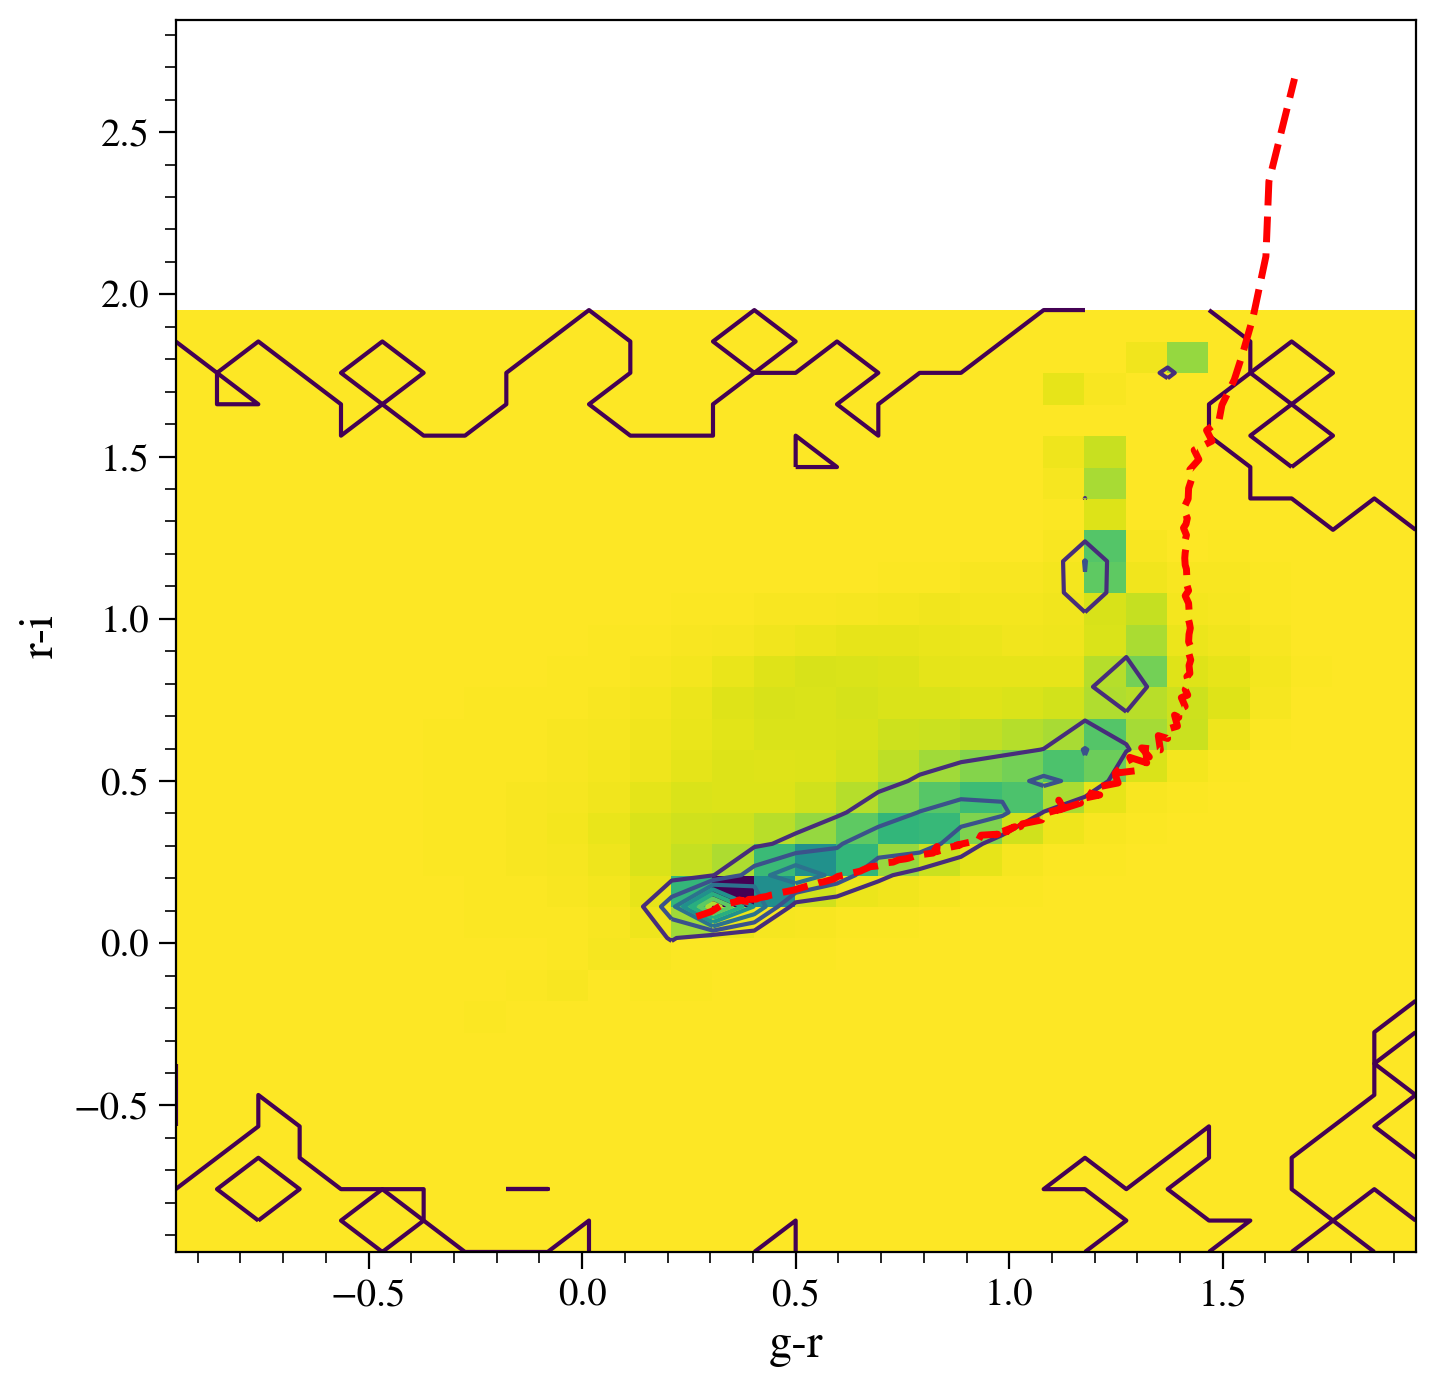

In [13]:
plot_color_color(df, 'gmr', 'rmi')
print('Using schema {}, cut on max err={}, found {} objects'.format(schema, max_err, nObj))

Now make the same plot, but for Run 1.2p data.  The query takes noticeably longer because the Run 1.2p catalog is about 5 times bigger than the one for Run 1.2i. For Run 2.1i dr1b v1 it takes over 30 minutes.

In [14]:
schema = 'run12p_v4'

global_cuts = 'clean '
t = None

min_SNR = 25   
max_err = 1/min_SNR
band_cuts = ' (magerr_g < {}) AND (magerr_i < {}) AND (magerr_r < {}) '.format(max_err,max_err,max_err)
where = ' WHERE ' + global_cuts + ' AND ' + band_cuts  
q7 = "SELECT mag_g,mag_r,mag_i FROM {schema}.dpdd ".format(**locals()) + where
print(q7)
records = []
with dbconn.cursor() as cursor:
    %time cursor.execute(q7)
    records = cursor.fetchall()
    nObj = len(records)
    
df = pd.DataFrame(records, columns=['mag_g', 'mag_r', 'mag_i'])

SELECT mag_g,mag_r,mag_i FROM run12p_v4.dpdd  WHERE clean  AND  (magerr_g < 0.04) AND (magerr_i < 0.04) AND (magerr_r < 0.04) 
CPU times: user 211 ms, sys: 226 ms, total: 437 ms
Wall time: 7min 15s


SELECT ra,dec FROM run12i.dpdd
Using schema run12p_v4 , max err=0.04, found 791346 objects


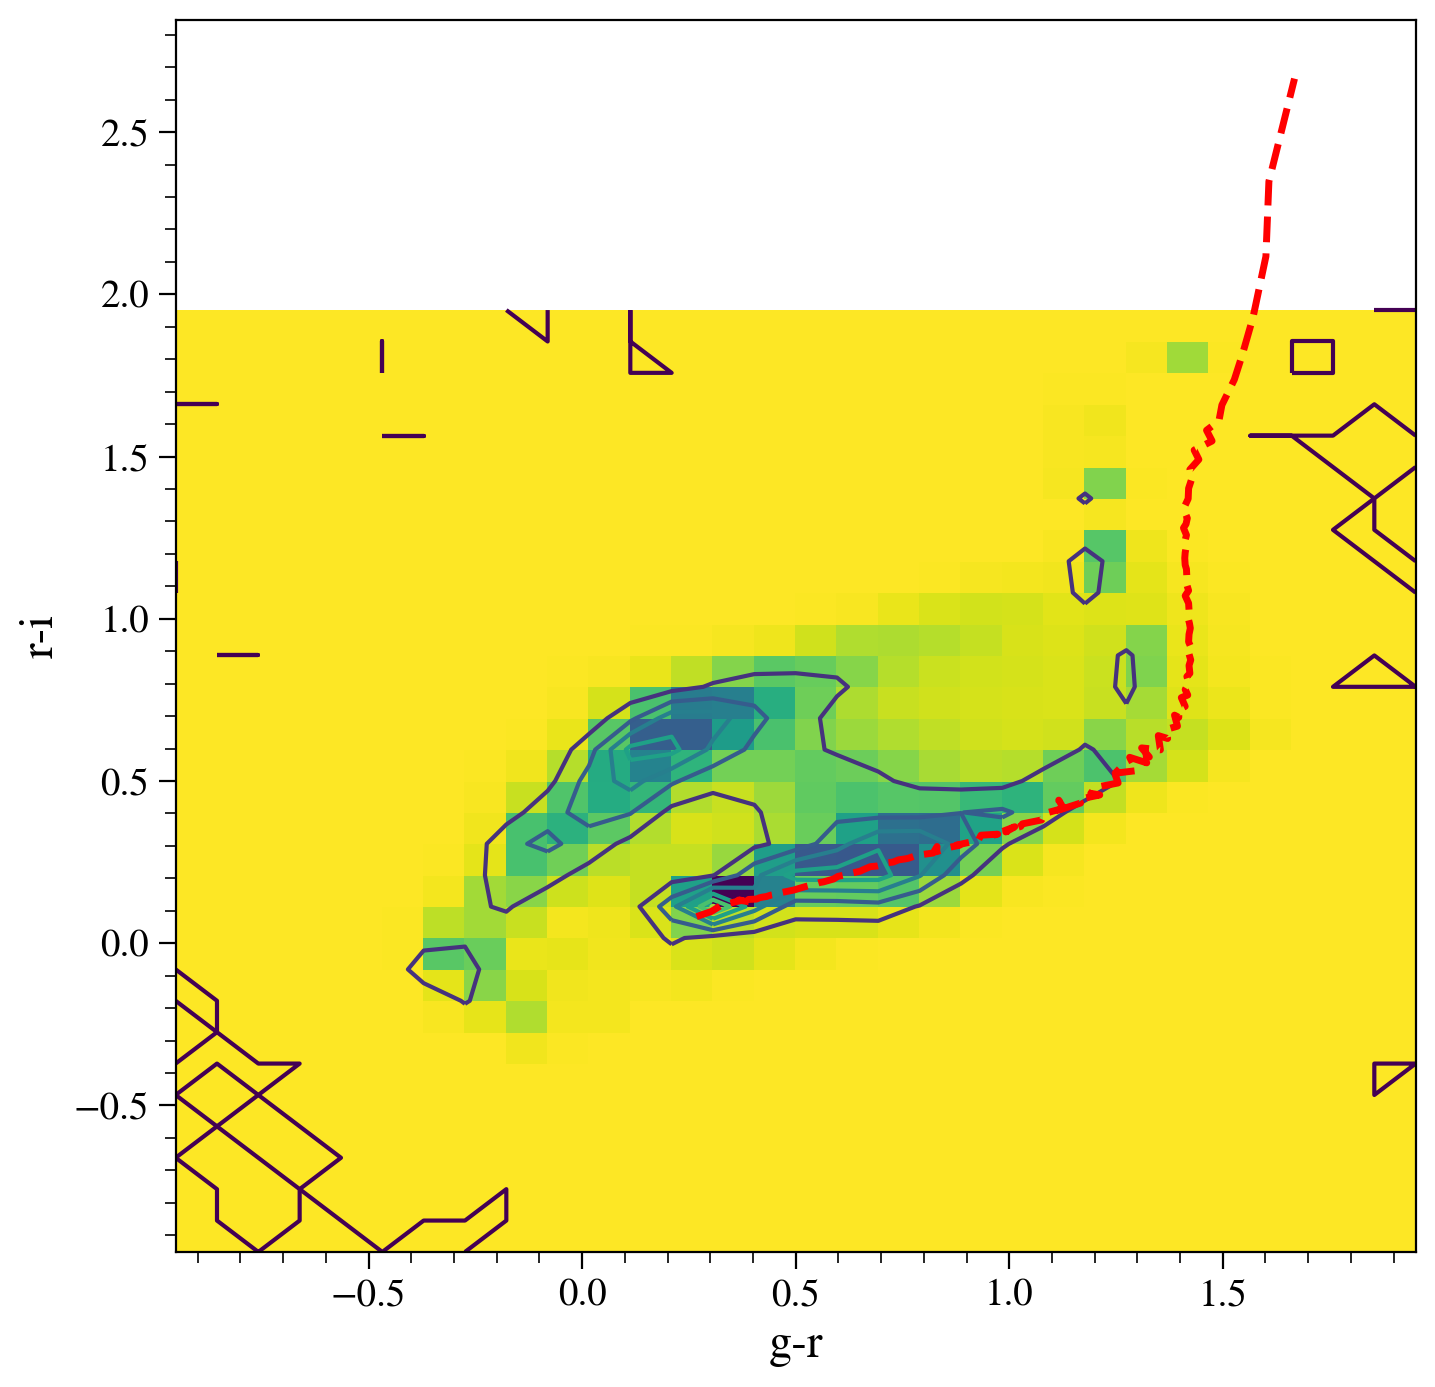

In [15]:
plot_color_color(df, 'gmr', 'rmi', title=t)
print(q5)
print('Using schema {} , max err={}, found {} objects'.format(schema, max_err, nObj))

Using schema run12p_v4, max err=0.04, found 791346 objects


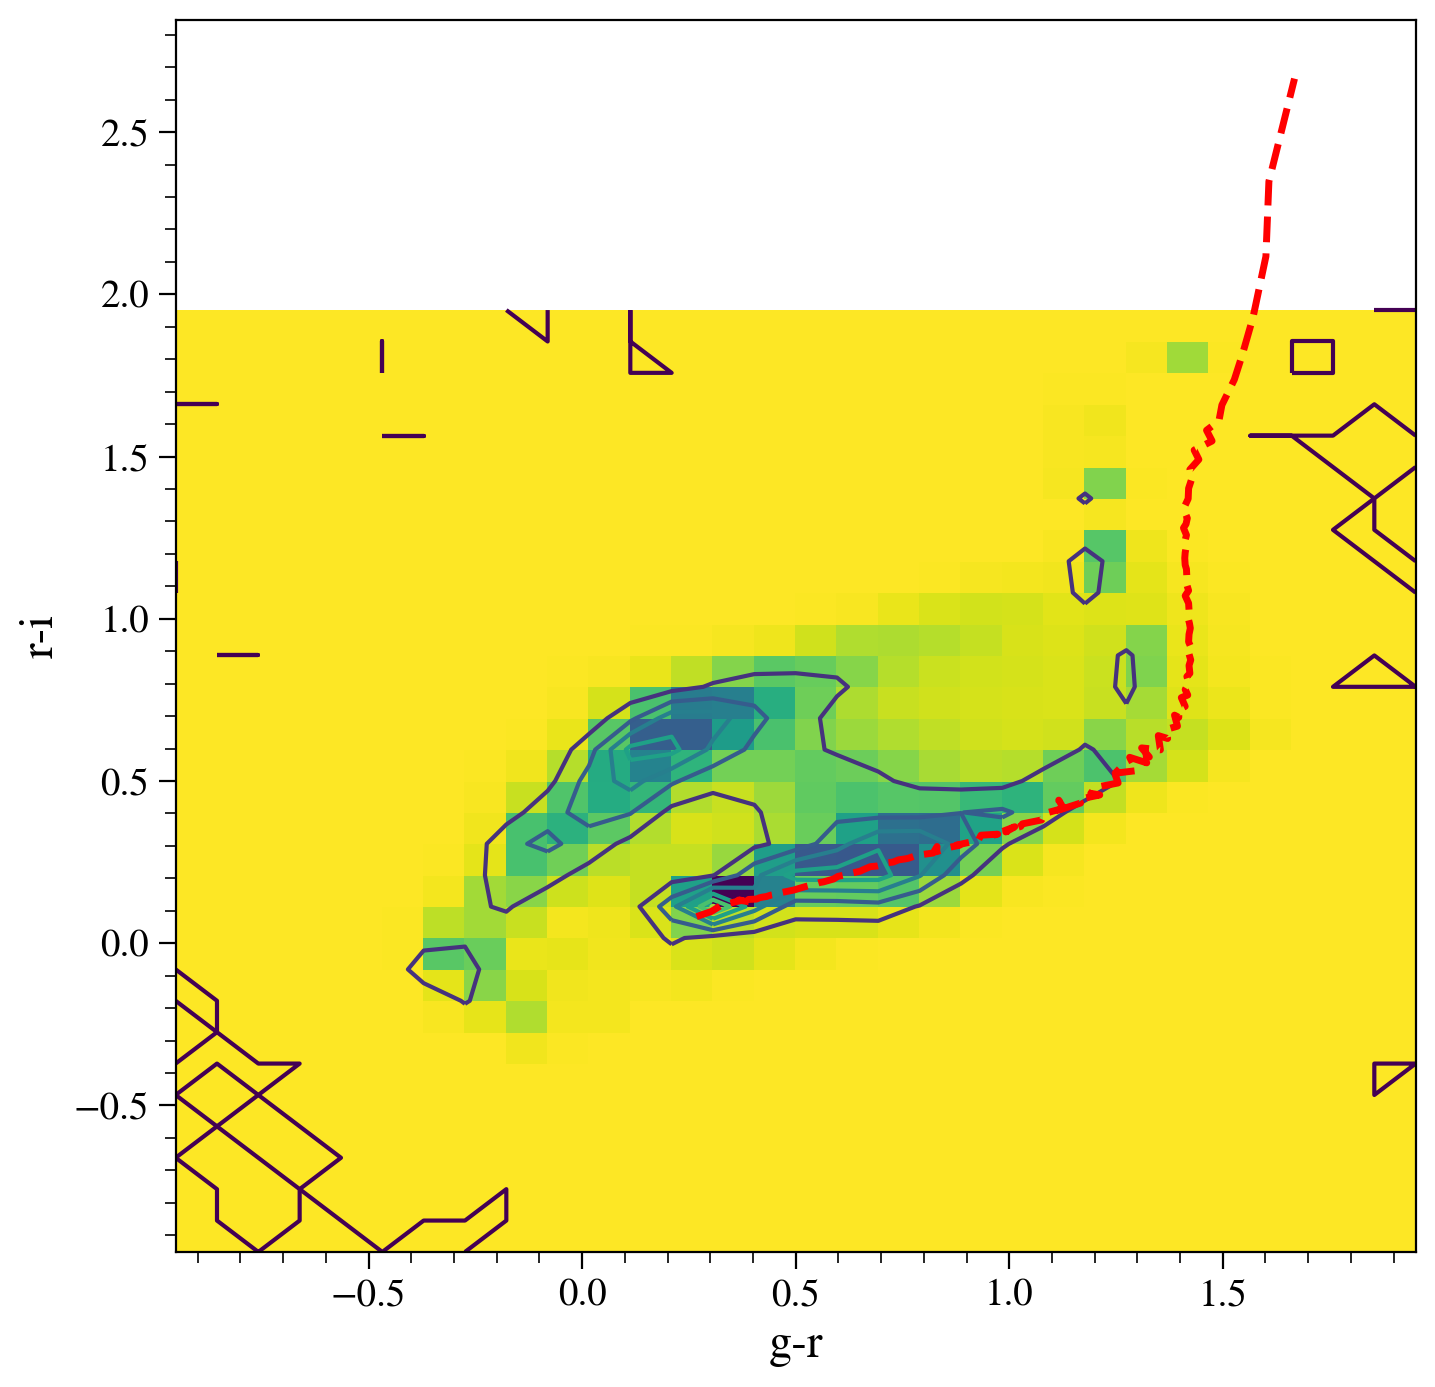

In [16]:
plot_color_color(df, 'gmr', 'rmi', title=t)
print(f'Using schema {schema}, max err={max_err}, found {nObj} objects')

## SQL Primer
This optional section is intended for those with little or no prior experience with an SQL database, in particular with a server-mediated database like PostgreSQL. Most of the material discussed here applies to SQLite as well but not all; differences are pointed out. Since the PostgreSQL database is read-only for users write operations like `INSERT` and `UPDATE` are not discussed.

For definitive answers to any questions concerning the Postgres implementation of SQL, consult the [manual](https://www.postgresql.org/docs/9.6/sql.html)
### Connecting to the Database
In order to use a database server (e.g. PostgreSQL, MySQL, Oracle) you have to supply connection information: host, database name, user name and password. That is precisely what the first block of code at the start of this tutorial above does. Everything is there but the password. That comes from a file accessible only to the user as described in the [Prerequisites section](#Prerequisites).

None of this is necessary for SQLite; all you need is read access to the file.  Opening the file with the Python sqlite3 module is the analog of the line `dbconn = psycopg2.connect(**dbconfig)` above

### Tables
#### Table definitions
A table definition contains a set of column definitions: a name, a datatype, and optional constraints. For example all values of the column can be required to be `NOT NULL` (i.e., every row must have a value for the column, which is not the default) or they can be required to be `UNIQUE`. Or both.  A table definition may also include index definitions.  An `INDEX`  is an extra data structure internal to the database which makes it faster to look up the column or columns which are indexed.
#### Table data
The data for each column must conform to the datatype of the column.  SQLite is pretty lax in this respect; PostgreSQL requires more. If a column is of type `TEXT` all literal values appearing in queries must be quoted, even if the value is a string of digits.  A query like this

`SELECT col1 FROM mytable WHERE col2=123;`

will fail for PostgreSQL if col2 is of type `TEXT`. SQLite allows it.
#### Views
A view has the same apparent structure as a table (a collection of rows, each with the same columns) and is used the same way in `SELECT` statements, but the column definitions and data actually come from one or more tables. In the definition of the view, columns from the table can be renamed and the collection of rows included may be subject to conditions, just as in a `SELECT` statement. Views can simplify the interface for users by eliminating the need for `JOIN`s in their queries and regularizing column names for commonly-used collections of columns which may come from multiple tables, as is the case for `run12p_v4.dpdd`. 

### Fetching data: SELECT
No matter what system you use to access a database, to fetch data someone (you or some service on your behalf) has to send a text string to the server that has this form : 

`SELECT` *things-to-fetch* `FROM` *table(s)-specification* *optional-selection-conditions* *other-optional-clauses*

and returns a table whose columns correspond to the *things-to-fetch* list.  Unlike parquet files or pandas dataframes, the returned data are physically ordered first by row, then column.

As in the rest of this tutorial, I follow the convention of writing keywords in `ALL CAPS` only to make them stand out; it's not necessary.

Examples come primarily from tables in the schema `star_truth`, in particular `truth_summary` and `stellar_variability_truth`. See [https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/postgres_truth.ipynb] to learn more about these tables.

#### What to fetch
*things-to-fetch* is a comma-separated list of expressions. The most common expression is simply a column name, but a wide variety of expressions are allowed, including functions applied to columns, for example

`SELECT id, ra, dec ...
 SELECT DISTINCT id
 SELECT MAX(ABS(delta_flux)), AVG(delta_flux) ...
 SELECT CONCAT(raft, '_', ccd), one_col + another_col, ...`
 
where, in the last example, the values of columns `raft` and `ccd` are text strings. `MAX` and `AVG` are **aggregate functions**, so-called because they apply to collections of column values rather than the value for a single row. `SELECT DISTINCT` eliminates duplicate rows from the output. The complete list of available functions and operators for PostgreSQL 9.6 (the version running at NERSC) can be found in their [comprehensive documentation](https://www.postgresql.org/docs/9.6/functions.html)


#### Table expressions
A *table expression* may identify a single table (or view) or multiple. For our PostgreSQL database, identifying a table requires a *schema name* and a *table name* separated by `.`; e.g. `star_truth.truth_summary`.

`SELECT MAX(ra), MIN(ra) from star_truth.truth_summary`

A query may involve more than one table, especially when the tables are related by a column which appears in both or some other expression involving columns. The table expression says how to `JOIN` (i.e., match) the tables to make a new temporary table from which values are selected.

`SELECT obshistid,delta_flux,S.id 
   FROM star_truth.truth_summary AS S 
   JOIN star_truth.stellar_variability_truth AS V 
   ON V.id = S.id 
   WHERE ABS(ra - 59.9) < 0.2 LIMIT 5`
   
or equivalently

`SELECT obshistid,delta_flux,id 
   FROM star_truth.truth_summary 
   JOIN star_truth.stellar_variability_truth
   USING (id)
   WHERE ABS(ra - 59.9) < 0.2 LIMIT 5`

In this query `ra` appears only in `truth_summary` whereas `delta_flux`, being a (per-object, per-visit) quantity, can only be in `stellar_variability_truth`. The quantity to be fetched is in one table, but the quantity needed to select rows of interest is in a different table (though in a real query you might want to fetch `ra` as well). The second form is a shorthand available when, as is often the case, the join condition is just the equality of columns from each table with the same name. The column name or list of column names in a `USING` expression must be enclosed in `( )`. 

The first example also illustrates the use of the keyword `AS` to define an alias to avoid having to retype long table specifications to qualify a column name. The extra qualification is only necessary if 
1. the column name appears in more than one table 
2. it's not in the `USING` list (hence unnecessary in the second example)

##### Technical details
There are different kinds of joins. The simplest (`T1 CROSS JOIN T2`) has no condition.  It's equivalent to `T1 INNER JOIN T2 ON TRUE`. The result is the Cartesian product of rows from T1 concatenated with rows from T2, not usually what you want. The syntax for the other kinds of joins all involve some kind of constraint or condition. They will return different results if one table or the other has rows which don't meet the condition; e.g., if a column to be matched has a NULL value for some row. For the example query it wouldn't matter which was used because every row in each of the two tables has a match with at least one row in the other table. `INNER` is the default so `JOIN` in the example is equivalent to `INNER JOIN`. 

#### Selection conditions
This is the (optional, but usually present) `WHERE` clause of a query. It's a boolean expression normally involving column names which is applied to each row of the table expression in `FROM`. Rows are included in the query result if and only if they evaluate to `TRUE`.  See the example in the preceding section. There are all kinds of complicated forms of `WHERE` clauses - for example they may include subqueries - but typical ones are just simple conditions involving columns and functions of columns, connected by `AND` or `OR`.

The `IN` operator can be useful: 

`SELECT delta_flux, id, obshistid  FROM star_truth.stellar_variability_truth 
   WHERE obshistid IN (2205, 7371, 10853);`

It's just shorthand for `(obshistid = 2205) OR (obshistid = 7371) OR (obshistid = 10853)`.

**NOTE:** In the SQL standard the test for equality is `A = B`, *not* `A == B`.  SQLite will let you get away with either; PostgreSQL will not.

#### Other optional clauses

##### GROUP BY
Groups returned rows together according to specified criteria. When there is a `GROUP BY` clause, each of the fetched items must either be something in the `GROUP BY` list or must involve an aggregate function (`MAX` and `COUNT` in the example below). 
`SELECT id, bandpass, MAX(ABS(delta_flux)), COUNT(obshistid)  FROM star_truth.stellar_variability_truth 
   WHERE id IN ('835183','31303590103','31102013522','31303588649', '30317268917', '30825472052','835279','31102039372','30825477672','31102046245', '30321363109','31102051190','31102061342') GROUP BY id,bandpass`
   
This query returns up to six rows for each `id` in the list.
##### ORDER BY
Return results in sorted order as specified. The results from the previous query are easier to deal with if sorted.
`SELECT id, bandpass, MAX(ABS(delta_flux)), COUNT(obshistid)  FROM star_truth.stellar_variability_truth 
   WHERE id IN ('835183','31303590103','31102013522','31303588649', '30317268917', '30825472052','835279','31102039372','30825477672','31102046245', '30321363109','31102051190','31102061342') GROUP BY id,bandpass ORDER BY id,bandpass`
   
##### LIMIT
Don't return more rows than the limit specified. Useful when you just want to see if a new query is working but don't want to wait for potentially large output.
#### Still more
 There are more ways to concoct the table expression.  There are more optional clauses. For the complete picture see the [section on SELECT](https://www.postgresql.org/docs/9.6/sql-select.html) in Postgres documentation.

## Using Python module psycopg2
There are plenty of examples of use in the first part of this tutorial.  This section extracts the basic patterns. It is specific to psycopg2 but other Python interfaces to Postgres or other databases (e.g. mysql.connector for MySQL; sqlalchemy if you stick to the core interface) are similarly structured. There are three things you need to do:
1. connect (normally once for many queries, but see warning below)
2. issue a query
3. obtain results from the query

### Connect
This is already described above, but for ease of reference it is repeated here:
1. Make a .pgpass file as in [Prerequisites](#Prerequisites) above.  You only need to do this once. 
2. Import psycopg2
3. Make a dict with other required connection information
4. Make the connection using the dict

The last three steps for our database at NERSC look like
```
 import psycopg2
   
 dbname = 'desc_dc2_drp'
 dbuser = 'desc_dc2_drp_user'
 dbhost = 'nerscdb03.nersc.gov'
 dbconfig = {'dbname' : dbname, 'user' : dbuser, 'host' : dbhost}
 dbconn = psycopg2.connect(**dbconfig)
```
**WARNING:** If all your subsequent queries succeed you will only need to make the connection once per script or notebook execution, but certain kinds of failures will make the connection unusable. In that case you need to re-execute the last line above.

 ### Issue a query
 As appropriate for your application, you will have created a string, call it q, which starts out `SELECT...`.  To execute it you get a cursor and call its `execute` method:
 ```
     cursor = dbconn.cursor()
     cursor.execute(q)
 ```
You can reuse the same cursor for another query as long as you obtain results from the first query before issuing the second.
 
**NOTE 1:** Unlike Python, SQL uses only single quotes `'` for string delimiters. A construction like this

`q = 'SELECT col1 FROM t1 WHERE col2 = "red" ' `

won't work because SQL doesn't recognize the `"`

`q = 'SELECT col1 FROM t1 WHERE col2='red' ' `

will fail because the internal single quotes aren't escaped. Fortunately Python is rich in quoting methods so you can just use another one for the outer string:

`q = "SELECT col1 FROM t1 WHERE col2='red'"`

```
q = '''SELECT col1 from t1 
        WHERE col2='red'
        AND col3='blue'
     '''
```

**NOTE 2:** In the first part of this tutorial I've used standard Python string formatting to assemble the query string. Alternatively, one can use an SQL-specific way to substitute parameters in a template.  That's the preferred method if the values for the variables come from an untrusted source, like a web page, and **definitely** should be used if such values may be used in writes to the database, but neither of those holds in our case. For a full explanation of how to use this method, see the section [Passing parameters to SQL queries](https://www.psycopg.org/docs/usage.html#passing-parameters-to-sql-queries) of the psycopg2 documentation.

### Retrieve results
Results are retrieved using cursor methods `fetchone()`, `fetchall()` and `fetchmany(size)` where the things fetched are *rows*. (In essence a row is a tuple whose components may be and usually are of different types.) The most appropriate method will depend on your application.  Use `fetchmany()` when you would ideally process all the data at once, but there is so much that it could strain resources like memory. The following shows a typical pattern of use

```
import psycopg2
import pandas as pd

dbconn = psycopg2.connect(db_dict)
 .
 .
q = ...
max_rows = 10000

# Cursor will automatically be closed at the end of the block
with dbconn.cursor() as cur:
    cur.execute(q)
    while True:
        rows = cur.fetchmany(max_rows)
        if len(rows) == 0:
            break
        df = pd.DataFrame(rows)
        process_some(df)
```
Putting the data in a DataFrame requires a copy; there is a limit to available memory.  Choosing an appropriate value for `max_rows` depends on knowing how much memory is available and how wide the rows are. 

## References
### PostgreSQL 9.6
The official documentation is generally clear and complete
1. [Everything](https://www.postgresql.org/docs/9.6/index.html)
2. [Postgres SQL syntax](https://www.postgresql.org/docs/9.6/sql-syntax.html)
3. [SELECT](https://www.postgresql.org/docs/9.6/queries.html)
4. [Functions and operators](https://www.postgresql.org/docs/9.6/functions.html)
5. [Additional spatial functions](https://github.com/LSSTDESC/DC2-PostgreSQL/blob/master/postgres-objcatalog/README_functions.md)
### psycopg2
1. [Project documentation](https://www.psycopg.org/docs/index.html)
2. [Wiki with simple examples](https://wiki.postgresql.org/wiki/Using_psycopg2_with_PostgreSQL#Connect_to_Postgres)